In [18]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2019, 1, 11)
end = datetime.datetime(2020, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-06,74.989998,73.187500,73.447502,74.949997,118387200.0,74.197395
2020-01-07,75.224998,74.370003,74.959999,74.597504,108872000.0,73.848442
2020-01-08,76.110001,74.290001,74.290001,75.797501,132079200.0,75.036385
2020-01-09,77.607498,76.550003,76.809998,77.407501,170108400.0,76.630219
2020-01-10,78.167503,77.062500,77.650002,77.582497,140644800.0,76.803459


In [19]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

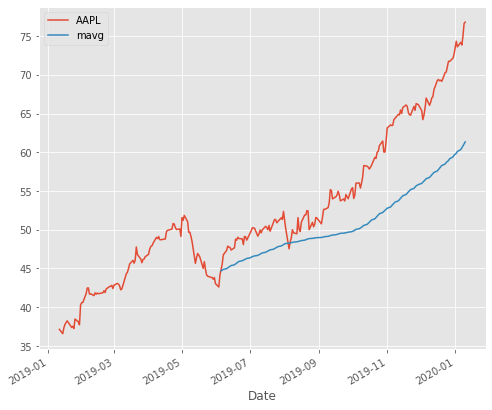

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

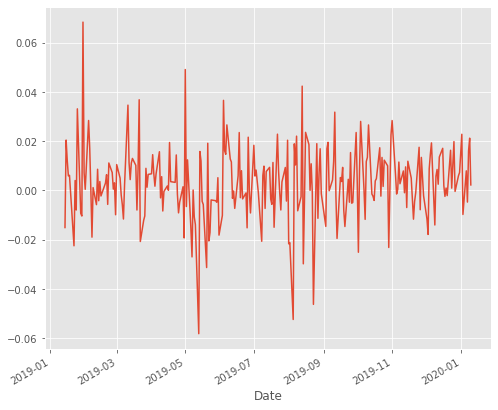

In [21]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [22]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [41]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.350604,0.547473,0.439788,0.595568
GE,0.350604,1.000000,0.243504,0.353166,0.273439
GOOG,0.547473,0.243504,1.000000,0.365681,0.601693
IBM,0.439788,0.353166,0.365681,1.000000,0.510195
MSFT,0.595568,0.273439,0.601693,0.510195,1.000000


Text(0, 0.5, 'Returns GE')

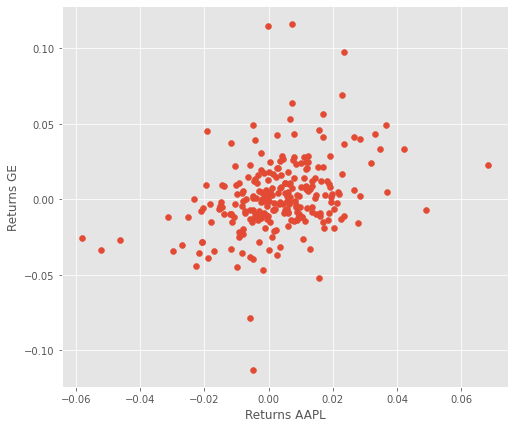

In [23]:
import matplotlib.pyplot as plt
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

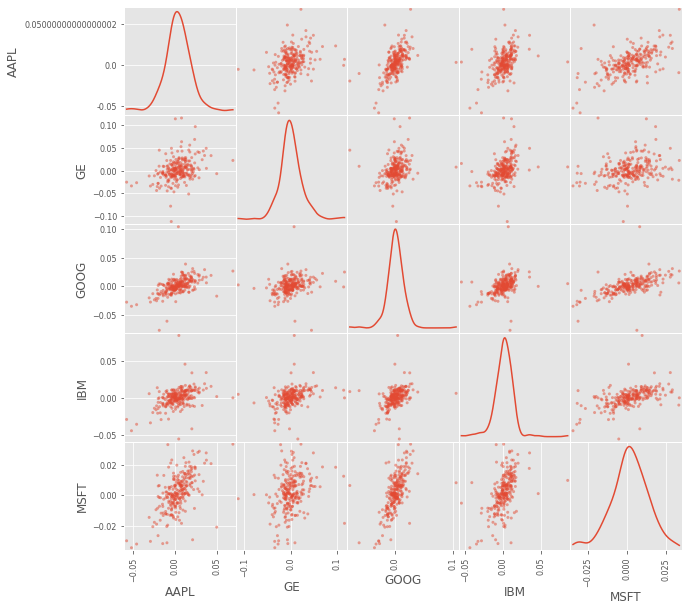

In [25]:
from pandas.plotting import scatter_matrix
scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));


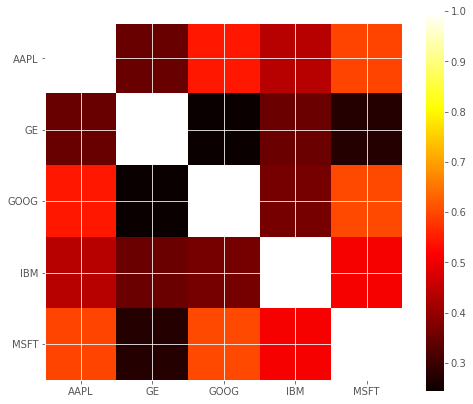

In [26]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

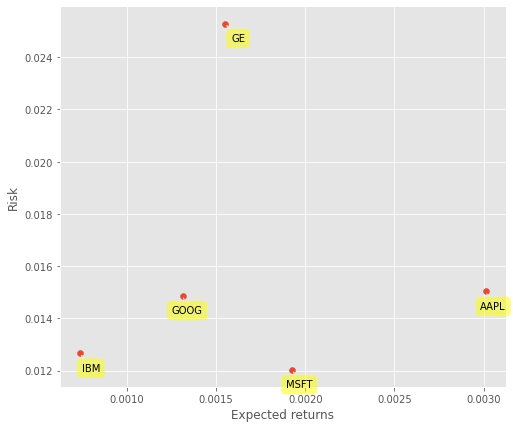

In [27]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [40]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg



,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-01-11,37.132290,108092800.0,1.438048,-0.385931
2019-01-14,36.573921,129756800.0,1.366669,-0.563478
2019-01-15,37.322472,114843600.0,2.182006,1.863315
2019-01-16,37.778423,122278800.0,1.858787,1.215051
2019-01-17,38.002739,119284800.0,2.823052,1.076526
...,...,...,...,...
2020-01-06,74.197395,118387200.0,2.404934,2.045672
2020-01-07,73.848442,108872000.0,1.146145,-0.483585
2020-01-08,75.036385,132079200.0,2.401134,2.029209


In [39]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]


In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline